In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from shapely.geometry import LineString, Point
from shapely.wkt import loads

import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  c:\Users\Davide\Git\pypsa-africa
Had to go 1 folder(s) up.


In [2]:
# load shapes
continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

In [24]:
df_lines_osm_download[df_lines_osm_download.Country == "TD"]#.dropna(subset=["tags.voltage"])

,Type,Length,id,tags.power,tags.cables,tags.voltage,tags.frequency,tags.circuits,Country,geometry
14433,Way,520.232263,189538516.0,line,None,None,None,None,TD,"LINESTRING (16.63526 7.92149, 16.63528 7.92203..."
14434,Way,4921.607573,197946959.0,line,None,None,None,None,TD,"LINESTRING (16.79324 8.53140, 16.79208 8.52914..."
14435,Way,172.318827,189538520.0,line,None,None,None,None,TD,"LINESTRING (16.63172 7.92310, 16.63149 7.92327..."
14436,Way,22973.810550,665135495.0,line,3,90000,50,None,TD,"LINESTRING (15.05158 12.21113, 15.05181 12.211..."
14437,Way,1789.468088,189508052.0,line,None,None,None,None,TD,"LINESTRING (16.64394 7.93936, 16.64357 7.93918..."
14438,Way,56.883020,189539622.0,line,None,None,None,None,TD,"LINESTRING (16.63340 7.92904, 16.63332 7.92883..."
14439,Way,55.620777,665135499.0,line,3,66000,50,None,TD,"LINESTRING (15.05157 12.21210, 15.05159 12.21161)"
14440,Way,1224.081252,189538519.0,line,None,None,None,None,TD,"LINESTRING (16.63733 7.91172, 16.63744 7.91177..."
14441,Way,20582.449341,198988186.0,line,None,None,None,None,TD,"LINESTRING (14.91263 12.37486, 14.91460 12.375..."
14442,Way,262.353056,288799105.0,line,None,None,None,None,TD,"LINESTRING (15.04436 12.35615, 15.04484 12.35389)"


<AxesSubplot:>

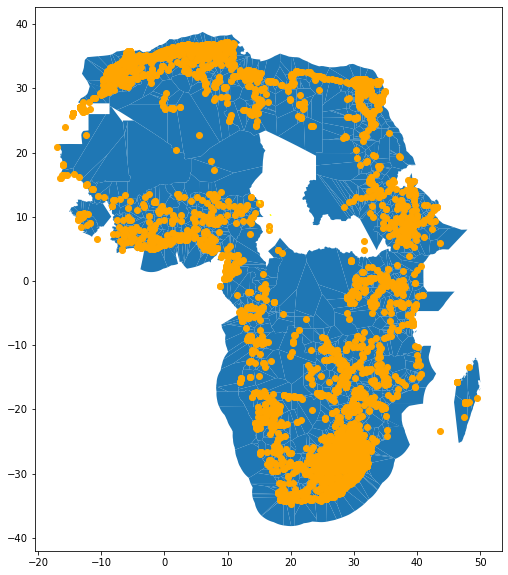

In [25]:
# plot output download_osm_data
df_substations_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_substations.geojson")
df_lines_osm_download = gpd.read_file(os.getcwd()+"/data/raw/africa_all_raw_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_download.plot(ax=ax, color="orange")
df_lines_osm_download.plot(ax=ax, color="yellow")
# df_lines_osm_download[df_lines_osm_download.Country == "TD"].plot(ax=ax, color="yellow")

<AxesSubplot:>

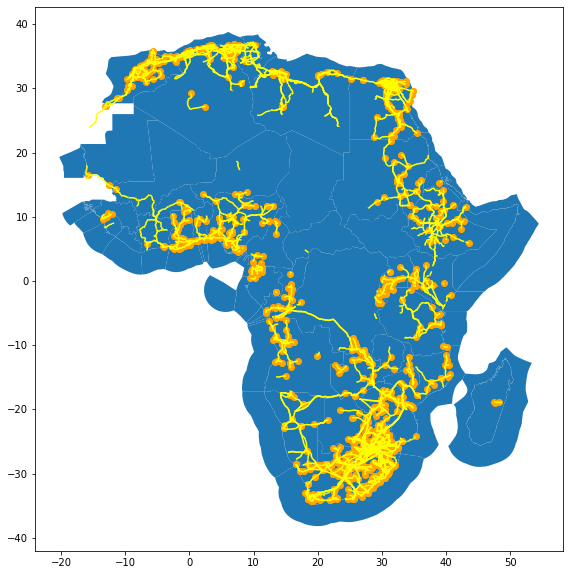

In [4]:
# plot output osm_data_cleaning
df_substations_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_substations.geojson")
df_lines_osm_clean = gpd.read_file(os.getcwd()+"/data/clean/africa_all_lines.geojson")

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_clean.plot(ax=ax, color="orange")
df_lines_osm_clean.plot(ax=ax, color="yellow")

C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:>

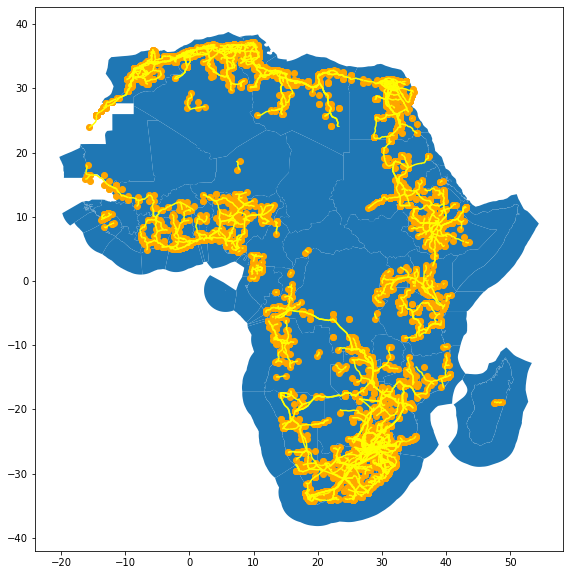

In [5]:
# plot output build_osm_network
df_substations_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_buses_build_network.csv")
df_lines_osm_build_network_pd = pd.read_csv(os.getcwd()+"/data/base_network/africa_all_lines_build_network.csv")

df_substations_osm_build_network_pd["geometry"] = gpd.points_from_xy(df_substations_osm_build_network_pd.lon, df_substations_osm_build_network_pd.lat)
#df_lines_osm_build_network_pd.dropna(subset="geometry", inplace=True)
df_lines_osm_build_network_pd["geometry"] = df_lines_osm_build_network_pd["geometry"].map(loads)

df_substations_osm_build_network = gpd.GeoDataFrame(geometry=df_substations_osm_build_network_pd.geometry, crs='epsg:4326')
df_lines_osm_build_network = gpd.GeoDataFrame(geometry=df_lines_osm_build_network_pd.geometry, crs='epsg:4326')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
df_substations_osm_build_network.plot(ax=ax, color="orange")
df_lines_osm_build_network.plot(ax=ax, color="yellow")

Index(['452716570-1'], dtype='object', name='name')
Index(['452716570-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network base.nc has buses, lines
C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


<AxesSubplot:>

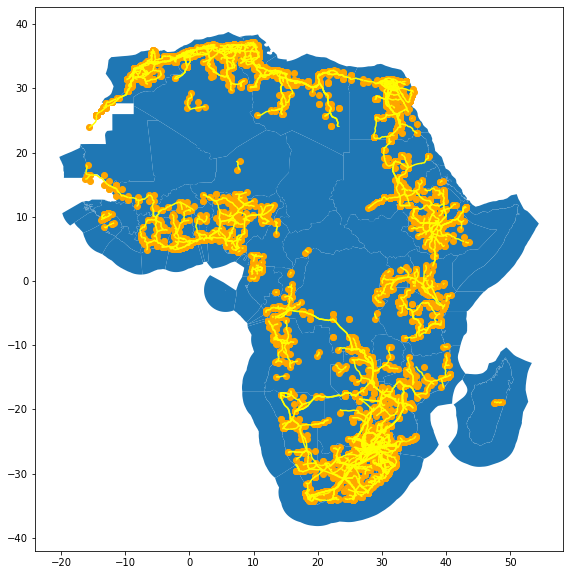

In [6]:
# plot output base_network
n = pypsa.Network(os.getcwd() + "/networks/base.nc")

lines_raw = n.lines.copy()
lines_raw["geometry"] = lines_raw["geometry"].map(loads)
# [LineString([Point(x.bus0_lon, x.bus0_lat), Point(x.bus1_lon, x.bus1_lat)]) for index, x in lines_raw.iterrows() 
#     if (x.bus0_lat is not None) and (x.bus0_lon is not None) and (x.bus1_lat is not None) and (x.bus1_lon is not None)]
lines = gpd.GeoDataFrame(geometry=lines_raw.geometry, crs='epsg:4326')

buses_raw = n.buses.copy()
buses_raw["geometry"] = gpd.points_from_xy(buses_raw.lon, buses_raw.lat)
buses = gpd.GeoDataFrame(geometry=buses_raw.geometry, crs='epsg:4326')

continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
buses.plot(ax=ax, color = "orange")
lines.plot(ax=ax, color = "yellow")


<AxesSubplot:>

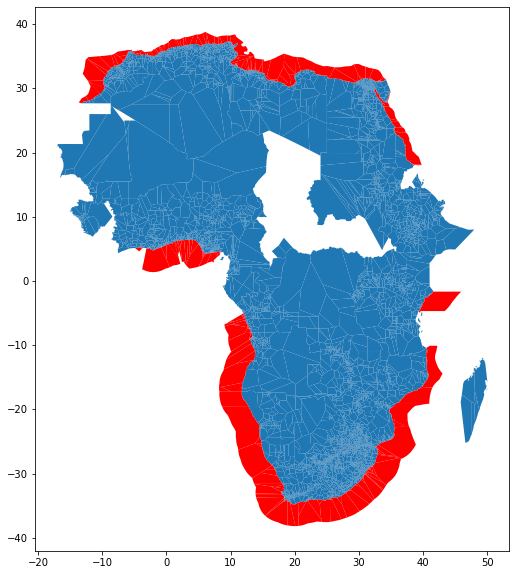

In [13]:
# plot output build_bus_regions

bus_regions_continent = gpd.read_file('resources/regions_onshore.geojson')
bus_regions_off_shore = gpd.read_file('resources/regions_offshore.geojson')

ax = bus_regions_continent.plot(figsize=(10,10))
bus_regions_off_shore.plot(ax=ax, color="red")